# Analyse réseau

In [9]:
from scapy.all import *
import pandas as pd


capture1 :
    protocole : 

capture2 :
    protocole : 

# Read

In [10]:
def read_pcap(file_path):
    packets = rdpcap(file_path)
    print(f"Nombre total de paquets dans {file_path}: {len(packets)}")

    return packets

In [11]:

# Lire le fichier pcap
capture1 = read_pcap("capture 1.pcapng")
capture2 = read_pcap("capture 2.pcapng")

Nombre total de paquets dans capture 1.pcapng: 100930
Nombre total de paquets dans capture 2.pcapng: 317593


## Create DF

### Information de chaque paquet

In [12]:
# Function to check for errors in packets
def check_for_errors(packet):
    if ICMP in packet:
        # Check for ICMP errors
        if packet[ICMP].type in [3, 11]:  # Destination Unreachable or Time Exceeded
            return True
    if IP in packet and packet[IP].proto == 1:  # ICMP protocol
        # Check for IP header errors
        if packet[IP].chksum != packet[IP].chksum_recv:
            return True
    return False

# Function to extract packet information and add error column
def extract_packet_info(packets):
    # Initialize lists to store packet information
    src_ip_list = []
    dst_ip_list = []
    src_port_list = []
    dst_port_list = []
    protocol_list = []
    packet_size_list = []
    time_delta_list = []
    packet_type_list = []
    error_list = []

    # Extract packet information
    prev_packet_time = None
    for packet in packets:
        # Extract source and destination IP addresses
        src_ip = packet[IP].src if IP in packet else None
        dst_ip = packet[IP].dst if IP in packet else None
        
        # Extract source and destination ports if available
        if IP in packet:
            src_port = packet[IP].sport if hasattr(packet[IP], 'sport') else None
            dst_port = packet[IP].dport if hasattr(packet[IP], 'dport') else None
        else:
            src_port, dst_port = None, None
        
        # Extract transport layer protocol if available
        protocol = packet[IP].proto if IP in packet else None
        
        # Extract packet size
        packet_size = len(packet)
        
        # Calculate time delta (time elapsed since the previous packet)
        current_packet_time = packet.time
        time_delta = current_packet_time - prev_packet_time if prev_packet_time else None
        prev_packet_time = current_packet_time

        # Extract packet type (data or control packet)
        packet_type = "Data" if packet.haslayer(Raw) else "Control"
        
        # Check for errors in the packet
        has_error = check_for_errors(packet)
        
        # Append extracted information and error status to lists
        src_ip_list.append(src_ip)
        dst_ip_list.append(dst_ip)
        src_port_list.append(src_port)
        dst_port_list.append(dst_port)
        protocol_list.append(protocol)
        packet_size_list.append(packet_size)
        time_delta_list.append(time_delta)
        packet_type_list.append(packet_type)
        error_list.append(has_error)

    # Create a DataFrame from the lists
    packet_df = pd.DataFrame({
        'Source_IP': src_ip_list,
        'Destination_IP': dst_ip_list,
        'Source_Port': src_port_list,
        'Destination_Port': dst_port_list,
        'Protocol': protocol_list,
        'Packet_Size': packet_size_list,
        'Time_Delta': time_delta_list,
        'Packet_Type': packet_type_list,
        'Error': error_list
    })

    return packet_df

In [13]:
capture1_df = extract_packet_info(capture1)
capture1_df.head()

,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Packet_Size,Time_Delta,Packet_Type,Error
0,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,60,None,Control,False
1,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,124,0.000332,Data,False
2,192.168.229.51,172.18.226.121,4500.0,64916.0,17.0,146,0.000002,Control,False
3,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,124,0.000159,Data,False
4,172.18.226.121,192.168.229.51,52255.0,10443.0,6.0,134,0.000002,Data,False


In [14]:
capture1_df["Protocol"].value_counts()

Protocol
6.0     58936
17.0    41075
2.0       100
89.0        8
Name: count, dtype: int64

In [15]:
# Filter packets with errors
error_packets = capture1_df[capture1_df['Error'] == True]

# Display the packets with errors
error_packets.head()

,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Packet_Size,Time_Delta,Packet_Type,Error


In [16]:
capture2_df = extract_packet_info(capture2)
capture2_df.head()

AttributeError: chksum_recv

### information de session

In [ ]:
def analyze_session(packet_df):
    # Group packets by session
    session_info = {}
    sessions = packet_df.groupby(['Source_IP', 'Destination_IP', 'Source_Port', 'Destination_Port', 'Protocol'])
    
    # Iterate over each session
    for session, packets in sessions:
        # Calculate session metrics
        packet_count = len(packets)
        avg_packet_size = packets['Packet_Size'].mean()
        avg_time_delta = packets['Time_Delta'].mean()
        
        # Extract additional session features
        min_packet_size = packets['Packet_Size'].min()
        max_packet_size = packets['Packet_Size'].max()
        total_bytes = packets['Packet_Size'].sum()
        unique_source_ips = packets['Source_IP'].nunique()
        unique_destination_ips = packets['Destination_IP'].nunique()
        unique_source_ports = packets['Source_Port'].nunique()
        unique_destination_ports = packets['Destination_Port'].nunique()
        most_common_protocol = packets['Protocol'].mode()[0]
        
        # Store session information
        session_info[session] = {
            'packet_count': packet_count,
            'average_packet_size': avg_packet_size,
            'average_time_delta': avg_time_delta,
            'min_packet_size': min_packet_size,
            'max_packet_size': max_packet_size,
            'total_bytes': total_bytes,
            'unique_source_ips': unique_source_ips,
            'unique_destination_ips': unique_destination_ips,
            'unique_source_ports': unique_source_ports,
            'unique_destination_ports': unique_destination_ports,
            'most_common_protocol': most_common_protocol
        }
    
    return session_info


In [ ]:
# Analyze the pcapng file and get session information
capture1_session_info = analyze_session(capture1_df)

In [ ]:
capture1_session_info_df = pd.DataFrame.from_dict(capture1_session_info, orient='index')
capture1_session_info_df.head()

packet_count  \
13.107.6.160   192.168.229.51 443.0   59984.0 6.0              8   
172.18.226.121 192.168.229.51 19335.0 4500.0  17.0             6   
                              52255.0 10443.0 6.0            176   
                              55015.0 10443.0 6.0             24   
                              58866.0 10443.0 6.0              3   

                                                    average_packet_size  \
13.107.6.160   192.168.229.51 443.0   59984.0 6.0            247.750000   
172.18.226.121 192.168.229.51 19335.0 4500.0  17.0           396.666667   
                              52255.0 10443.0 6.0            110.602273   
                              55015.0 10443.0 6.0            389.083333   
                              58866.0 10443.0 6.0            306.666667   

                                                    average_time_delta  \
13.107.6.160   192.168.229.51 443.0   59984.0 6.0             0.001928   
172.18.226.121 192.168.229.51 19335.0 4500.0  17.0            0.003009   
                              52255.0 10443.0 6.0             0.001030   
                              55015.0 10443.0 6.0             0.001713   
                              58866.0 10443.0 6.0             0.004855   

                                                    min_packet_size  \
13.107.6.160   192.168.229.51 443.0   59984.0 6.0                60   
172.18.226.121 192.168.229.51 19335.0 4500.0  17.0              194   
                              52255.0 10443.0 6.0                60   
                              55015.0 10443.0 6.0                60   
                              58866.0 10443.0 6.0                60   

                                                    max_packet_size  \
13.107.6.160   192.168.229.51 443.0   59984.0 6.0              1406   
172.18.226.121 192.168.229.51 19335.0 4500.0  17.0              770   
                              52255.0 10443.0 6.0               170   
                              55015.0 10443.0 6.0               590   
                              58866.0 10443.0 6.0               454   

                                                    total_bytes  \
13.107.6.160   192.168.229.51 443.0   59984.0 6.0          1982   
172.18.226.121 192.168.229.51 19335.0 4500.0  17.0         2380   
                              52255.0 10443.0 6.0         19466   
                              55015.0 10443.0 6.0          9338   
                              58866.0 10443.0 6.0           920   

                                                    unique_source_ips  \
13.107.6.160   192.168.229.51 443.0   59984.0 6.0                   1   
172.18.226.121 192.168.229.51 19335.0 4500.0  17.0                  1   
                              52255.0 10443.0 6.0                   1   
                              55015.0 10443.0 6.0                   1   
                              58866.0 10443.0 6.0                   1   

                                                    unique_destination_ips  \
13.107.6.160   192.168.229.51 443.0   59984.0 6.0                        1   
172.18.226.121 192.168.229.51 19335.0 4500.0  17.0                       1   
                              52255.0 10443.0 6.0                        1   
                              55015.0 10443.0 6.0                        1   
                              58866.0 10443.0 6.0                        1   

                                                    unique_source_ports  \
13.107.6.160   192.168.229.51 443.0   59984.0 6.0                     1   
172.18.226.121 192.168.229.51 19335.0 4500.0  17.0                    1   
                              52255.0 10443.0 6.0                     1   
                              55015.0 10443.0 6.0                     1   
                              58866.0 10443.0 6.0                     1   

                                                    unique_destination_ports  \
13.107.6.160   192.168.229.51 443.0   59984.0 6.0  

In [ ]:
capture2_session_info = analyze_session(capture2_df)

In [ ]:
capture2_session_info_df = pd.DataFrame.from_dict(capture2_session_info, orient='index')
capture2_session_info_df.head()

packet_count  \
10.200.0.130 128.92.92.124  4500.0 27012.0 17.0             2   
             172.18.226.121 1194.0 54841.0 17.0            41   
             197.230.3.138  4500.0 4500.0  17.0            11   
             213.4.210.241  4500.0 61849.0 17.0             3   
             223.71.132.50  4500.0 4500.0  17.0             1   

                                                 average_packet_size  \
10.200.0.130 128.92.92.124  4500.0 27012.0 17.0           118.000000   
             172.18.226.121 1194.0 54841.0 17.0           218.048780   
             197.230.3.138  4500.0 4500.0  17.0           133.272727   
             213.4.210.241  4500.0 61849.0 17.0           138.000000   
             223.71.132.50  4500.0 4500.0  17.0           118.000000   

                                                 average_time_delta  \
10.200.0.130 128.92.92.124  4500.0 27012.0 17.0            0.000049   
             172.18.226.121 1194.0 54841.0 17.0            0.000121   
             197.230.3.138  4500.0 4500.0  17.0            0.000211   
             213.4.210.241  4500.0 61849.0 17.0            0.000790   
             223.71.132.50  4500.0 4500.0  17.0            0.000002   

                                                 min_packet_size  \
10.200.0.130 128.92.92.124  4500.0 27012.0 17.0              118   
             172.18.226.121 1194.0 54841.0 17.0              106   
             197.230.3.138  4500.0 4500.0  17.0              118   
             213.4.210.241  4500.0 61849.0 17.0              134   
             223.71.132.50  4500.0 4500.0  17.0              118   

                                                 max_packet_size  total_bytes  \
10.200.0.130 128.92.92.124  4500.0 27012.0 17.0              118          236   
             172.18.226.121 1194.0 54841.0 17.0              315         8940   
             197.230.3.138  4500.0 4500.0  17.0              162         1466   
             213.4.210.241  4500.0 61849.0 17.0              146          414   
             223.71.132.50  4500.0 4500.0  17.0              118          118   

                                                 unique_source_ips  \
10.200.0.130 128.92.92.124  4500.0 27012.0 17.0                  1   
             172.18.226.121 1194.0 54841.0 17.0                  1   
             197.230.3.138  4500.0 4500.0  17.0                  1   
             213.4.210.241  4500.0 61849.0 17.0                  1   
             223.71.132.50  4500.0 4500.0  17.0                  1   

                                                 unique_destination_ips  \
10.200.0.130 128.92.92.124  4500.0 27012.0 17.0                       1   
             172.18.226.121 1194.0 54841.0 17.0                       1   
             197.230.3.138  4500.0 4500.0  17.0                       1   
             213.4.210.241  4500.0 61849.0 17.0                       1   
             223.71.132.50  4500.0 4500.0  17.0                       1   

                                                 unique_source_ports  \
10.200.0.130 128.92.92.124  4500.0 27012.0 17.0                    1   
             172.18.226.121 1194.0 54841.0 17.0                    1   
             197.230.3.138  4500.0 4500.0  17.0                    1   
             213.4.210.241  4500.0 61849.0 17.0                    1   
             223.71.132.50  4500.0 4500.0  17.0                    1   

                                                 unique_destination_ports  \
10.200.0.130 128.92.92.124  4500.0 27012.0 17.0                         1   
             172.18.226.121 1194.0 54841.0 17.0                         1   
             197.230.3.138  4500.0 4500.0  17.0                         1   
             213.4.210.241  4500.0 61849.0 17.0                         1   
             223.71.132.50  4500.0 4500.0  17.0                         1   

                                                 most_common_protocol  
10.200.0.130 128.92.92.124  4500.0 27012.0 17.0               

# Clustering

## packets

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def cluster_and_visualize(packet_df, features, n_clusters=3):
    # Prepare data
    X = packet_df[features]

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    packet_df['Cluster'] = kmeans.fit_predict(X)

    # Visualize clusters
    plt.figure(figsize=(10, 6))
    for cluster in range(n_clusters):
        cluster_data = packet_df[packet_df['Cluster'] == cluster]
        plt.scatter(cluster_data[features[0]], cluster_data[features[1]], label=f'Cluster {cluster}')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title('Clustering of Network Traffic')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
capture1_df.dropna(inplace=True)
capture2_df.dropna(inplace=True)


### capture 1

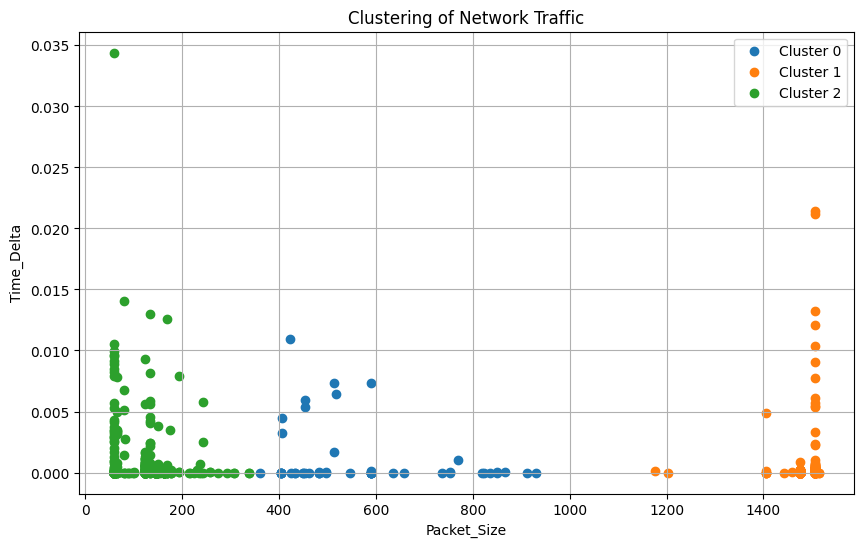

In [ ]:
# Example usage:
# Assuming 'packet_df' contains the DataFrame with packet data and 'features' is a list of selected features
cluster_and_visualize(capture1_df, ['Packet_Size', 'Time_Delta'])


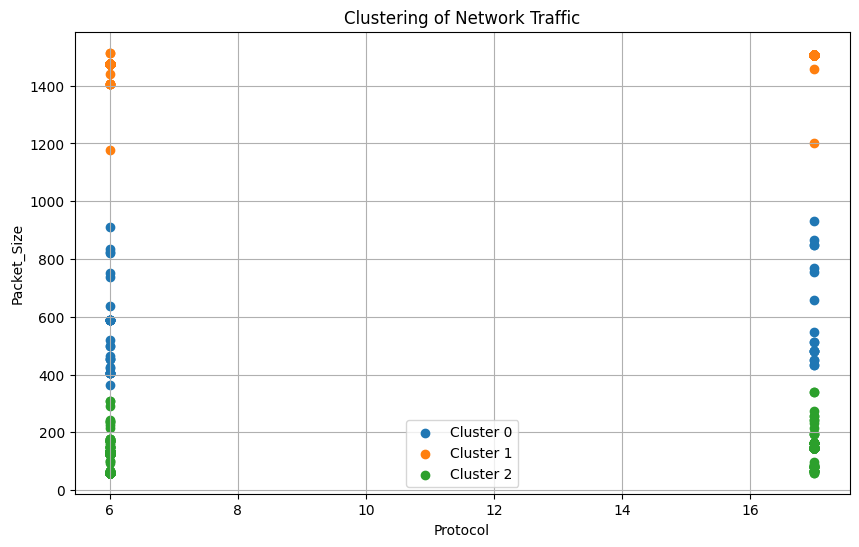

In [ ]:
cluster_and_visualize(capture1_df, ['Protocol', 'Packet_Size'])

### capture 2 

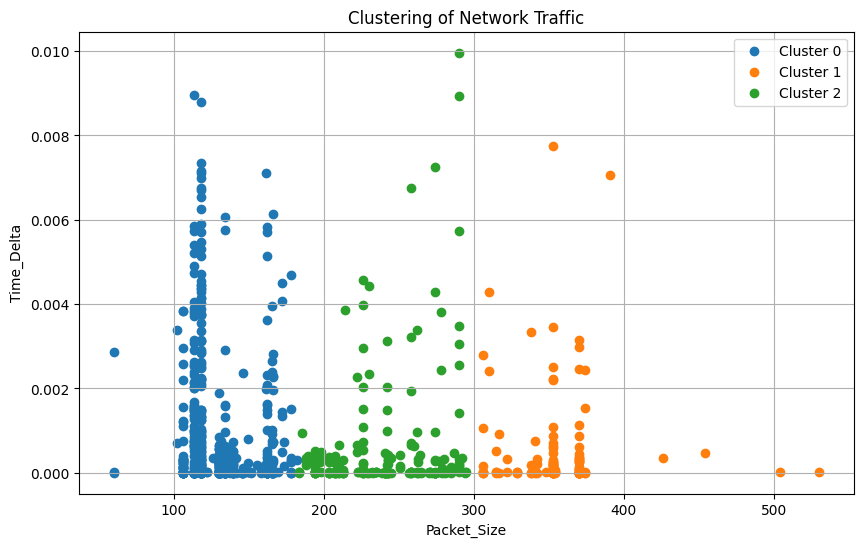

In [ ]:
cluster_and_visualize(capture2_df, ['Packet_Size', 'Time_Delta'])


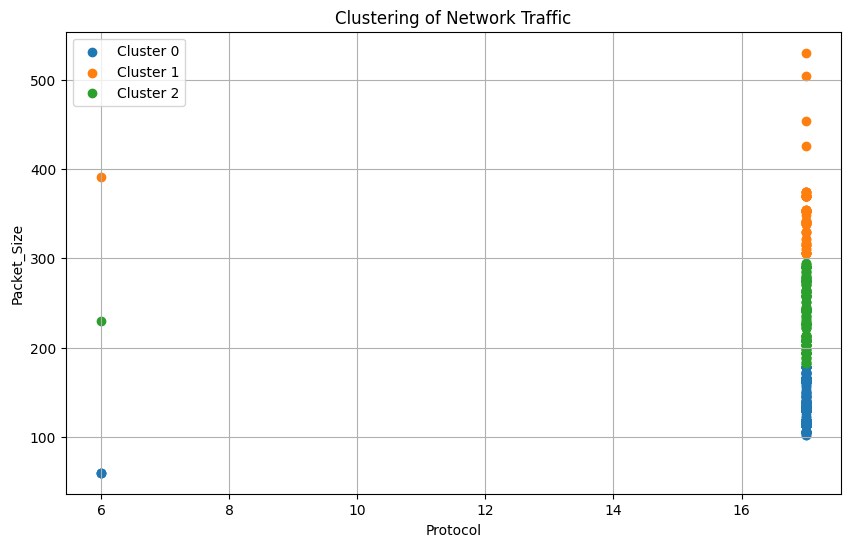

In [ ]:
cluster_and_visualize(capture2_df, ['Protocol', 'Packet_Size'])

## session

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def cluster_and_visualize(session_df, features, n_clusters=3):
    # Select the features for clustering
    X = session_df[features]

    # Apply standardization if necessary
    # (not always required, depends on the clustering algorithm and data distribution)
    # Example:
    # from sklearn.preprocessing import StandardScaler
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    session_df['Cluster'] = kmeans.fit_predict(X)

    # Visualize clusters
    plt.figure(figsize=(10, 6))
    for cluster in session_df['Cluster'].unique():
        cluster_data = session_df[session_df['Cluster'] == cluster]
        plt.scatter(cluster_data[features[0]], cluster_data[features[1]], label=f'Cluster {cluster}')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title('Clustering of Sessions')
    plt.legend()
    plt.show()




### session 1

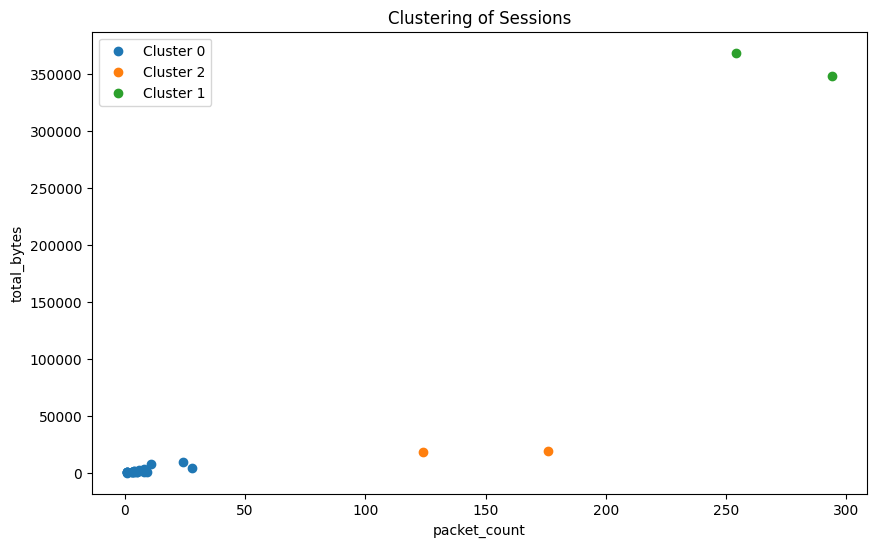

In [ ]:
# Example usage:
# Assuming 'session_df' contains the DataFrame with session data and 'features' is a list of selected features
cluster_and_visualize(capture1_session_info_df, ['packet_count', 'total_bytes'])

In [ ]:
capture1_session_info_df.columns

Index(['packet_count', 'average_packet_size', 'average_time_delta',
       'min_packet_size', 'max_packet_size', 'total_bytes',
       'unique_source_ips', 'unique_destination_ips', 'unique_source_ports',
       'unique_destination_ports', 'most_common_protocol', 'Cluster'],
      dtype='object')

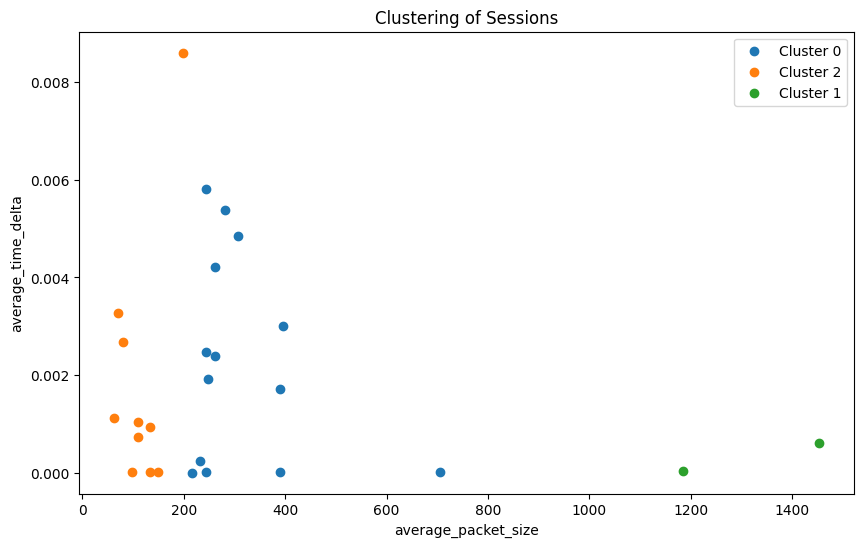

In [ ]:
cluster_and_visualize(capture1_session_info_df, ['average_packet_size', 'average_time_delta'])

### session 2

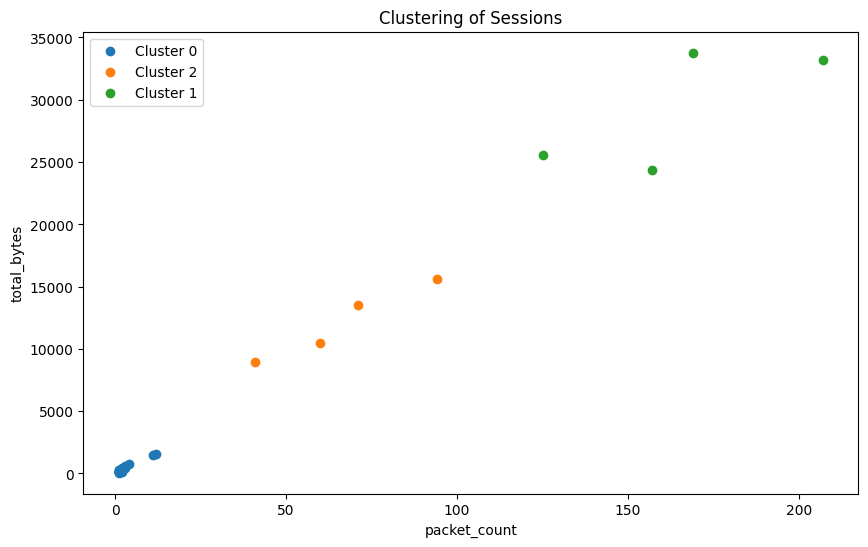

In [ ]:
cluster_and_visualize(capture2_session_info_df, ['packet_count', 'total_bytes'])

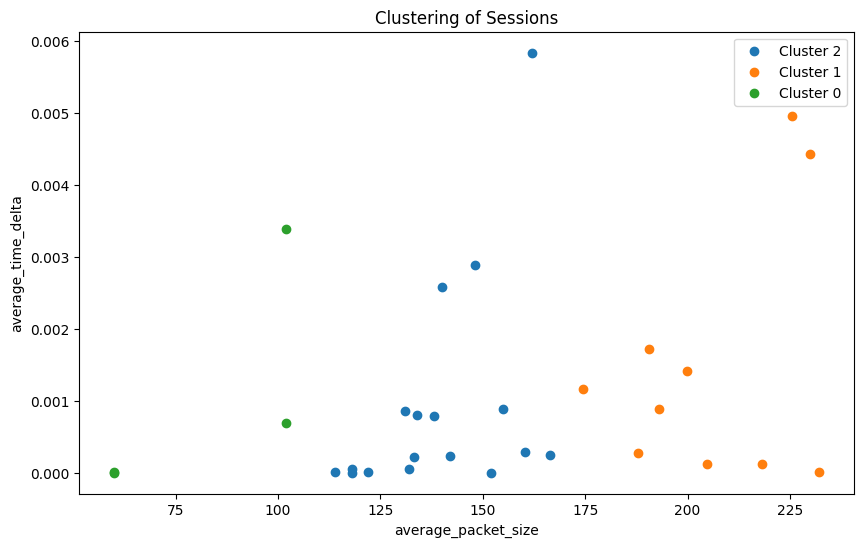

In [ ]:
cluster_and_visualize(capture2_session_info_df, ['average_packet_size', 'average_time_delta'])

# Detection d'anomalie

## packets